# Apple Support Chatbot Using Twitter Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import yaml
import emoji

## Data from Twitter

https://www.kaggle.com/thoughtvector/customer-support-on-twitter
- It is about customer support on tweet by different company

In [4]:
tweet = pd.read_csv('twcs.csv')
tweet.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [5]:
## Finding the different author in the data
author = tweet.groupby('author_id')['text'].count()
print(author)

## length of the dataframe
len(tweet), len(author)

author_id
10026                  3
100363                 1
10103                  2
10221                  2
10286                  1
                   ...  
mediatemplehelp      305
nationalrailenq     4444
sainsburys         19466
sizehelpteam        1482
sprintcare         22381
Name: text, Length: 702777, dtype: int64


(2811774, 702777)

In [6]:
author.nlargest(10)

author_id
AmazonHelp         169840
AppleSupport       106860
Uber_Support        56270
SpotifyCares        43265
Delta               42253
Tesco               38573
AmericanAir         36764
TMobileHelp         34317
comcastcares        33031
British_Airways     29361
Name: text, dtype: int64

- So there are 2.8 millions tweets and 700,000 different author_id
- Let's see the top 15

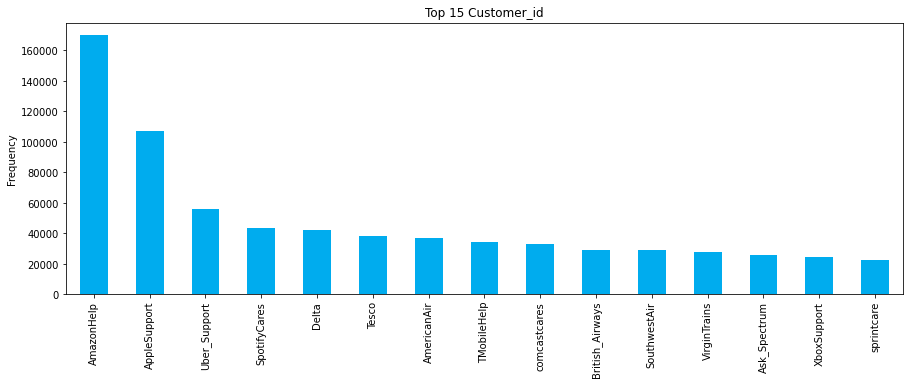

In [7]:
author.nlargest(15).plot(kind='bar',figsize=(15, 5), color='#00acee')
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Top 15 Customer_id')
# plt.savefig('')
plt.show()

In [8]:
## let's see unique customer_id and company
## by checking the inbound column we can see whether or not if it is the customer or not
unique_id = (len(tweet[tweet.inbound == False].author_id.unique()), len(tweet[tweet.inbound == True].author_id.unique()))
print(f'# of companies: {unique_id[0]}, # of customer: {unique_id[1]}')

# of companies: 108, # of customer: 702669


### Data Dictionary

The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

* tweet_id:
A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

* author_id:
A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

* inbound:
Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

* created_at:
Date and time when the tweet was sent.

* text:
Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

* response_tweet_id:
IDs of tweets that are responses to this tweet, comma-separated.

* in_response_to_tweet_id:
ID of the tweet this tweet is in response to, if any.

## Apple Support
- Creating a chatbot too broad and get us into lot of error by the bot because most customer support ask similar question, it can create internel errors
- Narrow it down to only Apple because Amazon has a lot of different languages in the text

In [9]:
ap = tweet[tweet['author_id'] == 'AppleSupport']
ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106860 entries, 396 to 2811541
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tweet_id                 106860 non-null  int64  
 1   author_id                106860 non-null  object 
 2   inbound                  106860 non-null  bool   
 3   created_at               106860 non-null  object 
 4   text                     106860 non-null  object 
 5   response_tweet_id        31564 non-null   object 
 6   in_response_to_tweet_id  106719 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 5.8+ MB


In [10]:
## we still have over 100,000 of data, so chatbot would be still decent
ap.shape

(106860, 7)

In [11]:
## we need to drop all the na for in_response_to_tweet_id because it shows the id of the tweet that this tweet is in response
ap.dropna(subset = ['in_response_to_tweet_id'], inplace = True)
## converting in_response_to_tweet_id to int
ap['in_response_to_tweet_id'] = ap['in_response_to_tweet_id'].astype('int64')
ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106719 entries, 396 to 2811541
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   tweet_id                 106719 non-null  int64 
 1   author_id                106719 non-null  object
 2   inbound                  106719 non-null  bool  
 3   created_at               106719 non-null  object
 4   text                     106719 non-null  object
 5   response_tweet_id        31423 non-null   object
 6   in_response_to_tweet_id  106719 non-null  int64 
dtypes: bool(1), int64(2), object(4)
memory usage: 5.8+ MB


<ipython-input-11-74ffd78d6e53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap.dropna(subset = ['in_response_to_tweet_id'], inplace = True)
<ipython-input-11-74ffd78d6e53>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap['in_response_to_tweet_id'] = ap['in_response_to_tweet_id'].astype('int64')


In [12]:
ap.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
396,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698
398,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697
401,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702
403,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704
405,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707


* now we need the match those text to the orginal in_response_to_tweet_id
* we can merge the orginal dataframe with the apple one
* we need the tweet_id and the text from the orginal one

In [13]:
ap = pd.merge(tweet[['tweet_id', 'text']], ap,left_on = 'tweet_id', right_on = 'in_response_to_tweet_id')
ap.head()

,tweet_id_x,text_x,tweet_id_y,author_id,inbound,created_at,text_y,response_tweet_id,in_response_to_tweet_id
0,697,@AppleSupport The newest update. I️ made sure ...,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697
1,698,@AppleSupport https://t.co/NV0yucs0lB,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698
2,702,@AppleSupport Tried resetting my settings .. r...,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702
3,704,@AppleSupport This is what it looks like https...,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704
4,707,@AppleSupport I️ have an iPhone 7 Plus and yes...,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707


In [14]:
## Dropping the unnesccary columns
ap.drop(columns = ['tweet_id_x', 'tweet_id_y', 'inbound', 'in_response_to_tweet_id', 'response_tweet_id'], inplace = True)
ap.head()

,text_x,author_id,created_at,text_y
0,@AppleSupport The newest update. I️ made sure ...,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...
2,@AppleSupport Tried resetting my settings .. r...,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...
3,@AppleSupport This is what it looks like https...,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...
4,@AppleSupport I️ have an iPhone 7 Plus and yes...,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...


In [15]:
## renaming them
ap.rename(columns = {'text_x': 'customer_text', 'text_y': 'apple_text', 'created_at': 'date'}, inplace = True)
ap.head()

,customer_text,author_id,date,apple_text
0,@AppleSupport The newest update. I️ made sure ...,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...
2,@AppleSupport Tried resetting my settings .. r...,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...
3,@AppleSupport This is what it looks like https...,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...
4,@AppleSupport I️ have an iPhone 7 Plus and yes...,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...


## Preprocessing 

In [16]:
# stopwords from nltk
stop_words = set(stopwords.words('english'))
# lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

ct = ap['customer_text']
ct 

0         @AppleSupport The newest update. I️ made sure ...
1                    @AppleSupport  https://t.co/NV0yucs0lB
2         @AppleSupport Tried resetting my settings .. r...
3         @AppleSupport This is what it looks like https...
4         @AppleSupport I️ have an iPhone 7 Plus and yes...
                                ...                        
106643    anyone having issues with #osx #HighSierra and...
106644    Hey @AppleSupport - not being able to duplicat...
106645    Yo @AppleSupport is that weird glitch w/ the c...
106646    What the fuck @AppleSupport  my phone keeps ha...
106647    Is anyone having #iphone issues with there pho...
Name: customer_text, Length: 106648, dtype: object

### Making all the words lower case

In [17]:
## converting to all lower case
ct = ct.str.lower()
ct

0         @applesupport the newest update. i️ made sure ...
1                    @applesupport  https://t.co/nv0yucs0lb
2         @applesupport tried resetting my settings .. r...
3         @applesupport this is what it looks like https...
4         @applesupport i️ have an iphone 7 plus and yes...
                                ...                        
106643    anyone having issues with #osx #highsierra and...
106644    hey @applesupport - not being able to duplicat...
106645    yo @applesupport is that weird glitch w/ the c...
106646    what the fuck @applesupport  my phone keeps ha...
106647    is anyone having #iphone issues with there pho...
Name: customer_text, Length: 106648, dtype: object

### Tokenzing, Lemmitzing, Remove the href

In [18]:
token = TweetTokenizer(reduce_len = True, strip_handles = True)
## this limits repeated character to 3 with reduce_len and strip_handles remove all the @
for i in range(len(ct)):
    ct[i] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', ct[i])
    ct[i] = lemmatizer.lemmatize(ct[i])
    ct[i] = token.tokenize(ct[i])
ct

0         [the, newest, update, ., i️, made, sure, to, d...
1                                                        []
2         [tried, resetting, my, settings, .., restartin...
3                         [this, is, what, it, looks, like]
4         [i️, have, an, iphone, 7, plus, and, yes, i️, do]
                                ...                        
106643    [anyone, having, issues, with, #osx, #highsier...
106644    [hey, -, not, being, able, to, duplicate, a, f...
106645    [yo, is, that, weird, glitch, w, /, the, capit...
106646    [what, the, fuck, my, phone, keeps, hanging, u...
106647    [is, anyone, having, #iphone, issues, with, th...
Name: customer_text, Length: 106648, dtype: object

### Stopwords and Remove the Emoji

In [27]:
clean = []
word = []
for i in ct:
    for j in i:
        if j not in stop_words:
            if j not in emoji.UNICODE_EMOJI:
                word.append(j)
    clean.append(word)
clean[1]

['newest',
 'update',
 '.',
 'i️',
 'made',
 'sure',
 'download',
 'yesterday',
 '.',
 'tried',
 'resetting',
 'settings',
 '..',
 'restarting',
 'phone',
 '..',
 'looks',
 'like',
 'i️',
 'iphone',
 '7',
 'plus',
 'yes',
 'i️',
 'i️',
 'need',
 'answers',
 '’',
 'annoying',
 '🙃',
 'hey',
 'anyone',
 'else',
 'upgraded',
 'ios',
 '11.1',
 ',',
 '’',
 'issues',
 'capital',
 '“',
 'i️',
 '”',
 'mail',
 'app',
 '?',
 'puts',
 '“',
 '”',
 '?',
 'happening',
 '...',
 'tf',
 'wrong',
 'keyboard',
 'call',
 'centres',
 'closed',
 'night',
 '?',
 'hello',
 'lines',
 'closed',
 'tonight',
 '#help',
 'i️',
 'upgraded',
 '.',
 'i️t',
 '’',
 'work',
 '.',
 'hello',
 ',',
 'internet',
 '.',
 'someone',
 'explain',
 'symbol',
 'keeps',
 'appearing',
 'phone',
 'i️',
 'try',
 'type',
 'letter',
 'i️',
 '?',
 'also',
 '’',
 'got',
 'screenshot',
 'saying',
 '#iphonex',
 'reserved',
 '3rd',
 'email',
 'saying',
 '’',
 '18th',
 '...',
 'happened',
 '?',
 'iphone',
 '6s',
 'plus',
 'recent',
 'update',
 

In [33]:
ct[2]

['tried',
 'resetting',
 'my',
 'settings',
 '..',
 'restarting',
 'my',
 'phone',
 '..',
 'all',
 'that']

In [34]:
type(clean)

list

In [25]:
len(clean)

106648

In [20]:
unique_emojis = [i[0] for i in emoji.UNICODE_EMOJI]
unique_emojis

['e', 'e', 'p', 'i']

In [ ]:
clean = pd.Series(clean)
clean